In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys

from scipy.fftpack import dctn, idctn

# Optics
lam   = 0.532     # wavelength (µm)

Upload and process experimental data to get wrapped phase picture

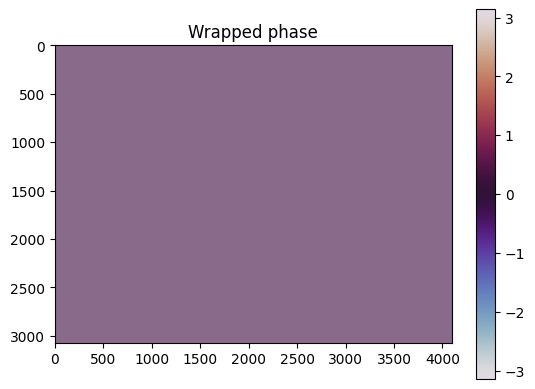

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import ndimage

# ---------------- Parameters (from your ODT_main) ----------------
pixelsizes = (0.00438, 0.00438)   # mm (dy, dx) = 4.38 µm
wavelength = 0.000632             # mm (632 nm)

FFT_filtering_params = {
    "center_padding": 100,
    "sample_filter_size": 250,
    "first_order_peak": None,
    "reference_hologram": None,
    "low_frequency_filter": None,
    "filter_type": "Linear",
    "smoothing_sigma": 2,
    "propagation_distance": 0.0,   # set nonzero (mm) if you want propagation
    "dtype": np.float32,
    "edge_remove": True,
}

# ---------------- FFT Filtering (copied from ODT_v) ----------------
def FFT_filtering(
    hologram: np.ndarray,
    pixelsize: tuple,
    center_padding: int,
    sample_filter_size: float,
    first_order_peak=None,
    reference_hologram=None,
    low_frequency_filter=None,
    filter_type='Linear',
    smoothing_sigma=None,
    wavelength=None,
    propagation_distance=None,
    dtype=np.float64,
    edge_remove=True,
):
    hologram = hologram.astype(dtype)
    if reference_hologram is not None:
        reference_hologram = reference_hologram.astype(dtype)

    def shift_data(data, shift):
        dy, dx = map(int, shift)
        return np.roll(np.roll(data, dy, axis=0), dx, axis=1)

    def filtering(data, radius, center):
        if filter_type == 'Linear':
            mask = np.sqrt((FxGrid - center[0])**2 + (FyGrid - center[1])**2) < radius
        elif filter_type == 'Gaussian':
            sigma = radius / 3
            mask = np.exp(-((FxGrid - center[0])**2 + (FyGrid - center[1])**2) / (2 * sigma**2))
        return data * mask + 1e-6

    def angular_spectrum_propagation(field, zshift):
        k = 2 * np.pi / wavelength
        H = np.exp(1j * zshift * np.sqrt(np.maximum(0, k**2 - (2*np.pi*FxGrid)**2 - (2*np.pi*FyGrid)**2)))
        return np.fft.ifft2(np.fft.fft2(field) * H)

    Ny, Nx = hologram.shape
    dy, dx = pixelsize
    fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=dy))
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=dx))
    FxGrid, FyGrid = np.meshgrid(fx, np.flip(fy))

    spectrum = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(hologram)))

    if first_order_peak is None:
        spectrum_log = np.log10(np.abs(spectrum) / np.max(np.abs(spectrum)))
        if edge_remove:
            spectrum_log[:center_padding, :] = np.nan
            spectrum_log[-center_padding:, :] = np.nan
            spectrum_log[:, :center_padding] = np.nan
            spectrum_log[:, -center_padding:] = np.nan
        spectrum_log[FyGrid <= center_padding] = np.nan
        peak_idx_flat = np.nanargmax(spectrum_log)
        first_order_peak = np.unravel_index(peak_idx_flat, spectrum_log.shape)

    filter_center = (FxGrid[first_order_peak], FyGrid[first_order_peak])

    spectrum_filtered = filtering(spectrum, sample_filter_size, filter_center)
    spectrum_centered = shift_data(spectrum_filtered, [Ny//2 - first_order_peak[0], Nx//2 - first_order_peak[1]])
    hologram_filtered = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(spectrum_centered)))

    if reference_hologram is not None:
        spectrum_ref = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(reference_hologram)))
        spectrum_ref_filtered = filtering(spectrum_ref, sample_filter_size, filter_center)
        spectrum_ref_centered = shift_data(spectrum_ref_filtered, [Ny//2 - first_order_peak[0], Nx//2 - first_order_peak[1]])
        hologram_refexp = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(spectrum_ref_centered)))
        hologram_sample = hologram_filtered / hologram_refexp
    else:
        hologram_sample = hologram_filtered

    if propagation_distance is not None and propagation_distance != 0:
        hologram_sample = angular_spectrum_propagation(hologram_sample, propagation_distance)

    phase_wrapped = np.angle(hologram_sample)
    return phase_wrapped

# ---------------- Simple wrapper ----------------
def get_wrapped_phase(image_path):
    hologram = np.array(Image.open(image_path)).astype(np.float32)
    return FFT_filtering(hologram, pixelsizes, **FFT_filtering_params)

# ---------------- Run ----------------
filename = "../docs/Angle-188.838.tiff"  # adjust path if needed
wrapped_phase = get_wrapped_phase(filename)

plt.imshow(wrapped_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.title("Wrapped phase")
plt.show()
